#**Práctica 03**
##Auri Morro: F0573326
##Diego Delgado:
##Álvaro:

##**Pregunta 4:**

### Implemente una red neuronal con la database Default (puede encontrar el set de datos aquí). Use una capa oculta con 10 unidades y regularización por droput. Compare el desempeño de clasificación con respecto al de la regresión lineal.

## 1. Install and import libraries

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', message="Coordinate descent without L1 regularization may lead to unexpected results and is discouraged.")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
# Basic
import numpy as np
import pandas as pd
import requests
import json

# Plotting
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
import sklearn.linear_model as skl

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence

# TensorFlow
from tensorflow.keras.datasets import mnist, cifar100, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Fit Linear Methods and Single Layer Neural Network

First we perform the data cleaning stage.

In [14]:
# Load the Default csv dataset
Default = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/default.csv')

In [15]:
# Mostrar las columnas de la base de datos
Default.columns

Index(['Unnamed: 0', 'default', 'student', 'balance', 'income'], dtype='object')

In [16]:
#Mostrar por pantalla las dimensiones del DataFrame, el número de datos que
#contiene, los nombres de sus columnas y filas, los tipos de datos de las columnas,
Default.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [18]:
print(Default.columns)


Index(['Unnamed: 0', 'default', 'student', 'balance', 'income'], dtype='object')


In [20]:
#las 10 primeras filas
Default.head(10)

,Unnamed: 0,default,student,balance,income
0,0,No,No,729.526495,44361.625074
1,1,No,Yes,817.180407,12106.134700
2,2,No,No,1073.549164,31767.138947
3,3,No,No,529.250605,35704.493935
4,4,No,No,785.655883,38463.495879
5,5,No,Yes,919.588530,7491.558572
6,6,No,No,825.513331,24905.226578
7,7,No,Yes,808.667504,17600.451344
8,8,No,No,1161.057854,37468.529288
9,9,No,No,0.000000,29275.268293


In [23]:
Default = Default.dropna()
Default = pd.get_dummies(Default, dtype='int')
Default = Default.drop(columns = ['student_Yes','student_No',  ])
Default = Default.reindex()
Default.shape

(10000, 5)

We can split dataset using the ``train_test_split`` method from Scikit-Learn library

In [28]:
#las 10 primeras filas
Default.head(10)

,Unnamed: 0,balance,income,default_No,default_Yes
0,0,729.526495,44361.625074,1,0
1,1,817.180407,12106.134700,1,0
2,2,1073.549164,31767.138947,1,0
3,3,529.250605,35704.493935,1,0
4,4,785.655883,38463.495879,1,0
5,5,919.588530,7491.558572,1,0
6,6,825.513331,24905.226578,1,0
7,7,808.667504,17600.451344,1,0
8,8,1161.057854,37468.529288,1,0
9,9,0.000000,29275.268293,1,0


In [29]:
target = [ 'default_Yes' ]
predictors = [ var for var in Default.columns if var not in target ]

In [30]:
X_train, X_test, y_train, y_test = skm.train_test_split(Default[predictors], Default[target], test_size=0.33, random_state=0)

Now let's fit the following Linear Models:

- **Linear Regression:** A basic linear regression model is created, trained, and predictions are made on the test set. The MSE is computed for the predictions.

- **Ridge Regression:** A Ridge model is set up using ElasticNetCV with ``l1_ratio`` set to 0, indicating it's purely Ridge. The model undergoes K-Fold cross-validation to tune the lambda (regularization strength) parameter. Predictions are made on the test set and the MSE is calculated.

- **Lasso Regression:** Similar to Ridge, a Lasso model is implemented using ElasticNetCV, but with ``l1_ratio`` set to 1, indicating it's purely Lasso. The model is also subjected to K-Fold cross-validation for lambda tuning. Finally, predictions are made and the MSE is computed.

In [31]:
# Linear Regression

lr_model = skl.LinearRegression()
lr_model.fit( X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = round( mean_squared_error(y_test, y_pred_lr), 3 )

In [32]:
# Ridge

cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)
lambdas = 10**np.linspace(8, -2, 100)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=cv)
scaler = StandardScaler()
pipeCV_ridge = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV_ridge.fit(X_train, y_train)
y_pred_ridge = pipeCV_ridge.predict(X_test)
mse_ridge = round( mean_squared_error(y_test, y_pred_ridge), 3 )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
# Lasso

LassoCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=cv)
pipeCV_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', LassoCV)])
pipeCV_lasso.fit(X_train, y_train)
y_pred_lasso = pipeCV_lasso.predict(X_test)
mse_lasso = round( mean_squared_error(y_test, y_pred_lasso), 3 )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now let's fit a Single Layer Neural Network

- **Input and Hidden Layer:** The model starts with a densely connected layer (Dense) with 50 neurons, utilizing ReLU (Rectified Linear Unit) as the activation function. This layer is designed to receive input with a shape corresponding to the number of predictors in the dataset.

- **Dropout Layer:** A dropout layer is included to prevent overfitting. It randomly sets a portion of the input units (40% in this case) to 0 during training, which helps in making the model more robust and prevents over-reliance on specific input features.

- **Output Layer:** The output layer consists of a single neuron, as this is a regression model expected to predict a continuous value.

- **Compilation:** The model is compiled with the Mean Squared Error (mean_squared_error) loss function, suitable for regression tasks. The RMSprop optimization algorithm is used for training the model.
Training:

- **Training:** The model is trained for 1500 epochs with a batch size of 32. Validation data is also provided to monitor the model's performance on a separate test set during training.

In [37]:
modnn = Sequential()
modnn.add(Dense(units=10, activation='relu', input_shape=(len(predictors),)))
modnn.add(Dropout(rate=0.4))
modnn.add(Dense(units=1))

In [39]:
modnn.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['mean_squared_error'])

In [40]:
history = modnn.fit(X_train, y_train,
                    epochs=1500, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/1500
210/210 [==============================] - 1s 3ms/step - loss: 27.5466 - mean_squared_error: 27.5466 - val_loss: 0.3346 - val_mean_squared_error: 0.3346
Epoch 2/1500
210/210 [==============================] - 1s 3ms/step - loss: 264.6587 - mean_squared_error: 264.6587 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 3/1500
210/210 [==============================] - 0s 2ms/step - loss: 232.6104 - mean_squared_error: 232.6104 - val_loss: 0.3243 - val_mean_squared_error: 0.3243
Epoch 4/1500
210/210 [==============================] - 1s 3ms/step - loss: 253.7112 - mean_squared_error: 253.7112 - val_loss: 0.2863 - val_mean_squared_error: 0.2863
Epoch 5/1500
210/210 [==============================] - 0s 2ms/step - loss: 6.3760 - mean_squared_error: 6.3760 - val_loss: 1.5782 - val_mean_squared_error: 1.5782
Epoch 6/1500
210/210 [==============================] - 1s 3ms/step - loss: 40.7105 - mean_squared_error: 40.7105 - val_loss: 2.0580 - val_mean_squared_error: 2.0580


We compute the test error for the Single Layer Neural Network

In [41]:
y_pred_nn = modnn.predict(X_test)
mse_nn = round( mean_squared_error(y_test, y_pred_nn), 3 )
mse_nn

104/104 [==============================] - 0s 1ms/step


5.212

We can compare the performance of the different models here

In [42]:
mse_values = {
    'Linear Regression': mse_lr, 'Ridge': mse_ridge, 'Lasso': mse_lasso, 'Neural Network': mse_nn
}
mse_df = pd.DataFrame(list(mse_values.items()), columns=['Model', 'MSE'])
mse_df

,Model,MSE
0,Linear Regression,0.000
1,Ridge,0.000
2,Lasso,0.000
3,Neural Network,5.212


We can visualize the Mean Squared Error for the Single Layer Neural Network over different epochs

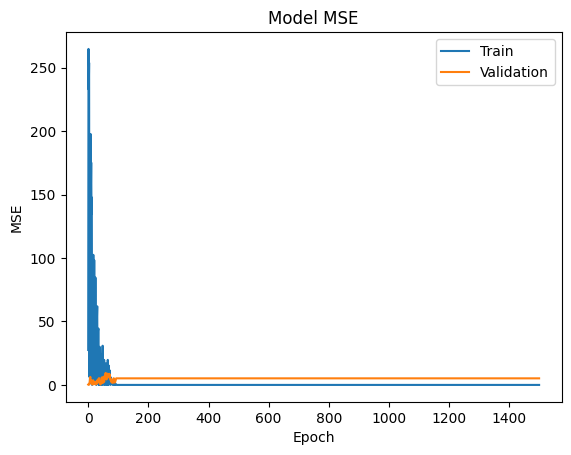

In [43]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Entenderia que los valores son muy bajos o el que tiene mejor desempeño es el de REGRESION LINEAL , RIDGE Y LASO